In [6]:
import sys,os
sys.path.append("../")

import pandas as pd
import numpy as np
import pickle
from sklearn.cluster import DBSCAN

import matplotlib.pyplot as plt
from IPython.display import HTML
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

%matplotlib inline


In [8]:
def get_word_vecs(wiki_vec, vocab, tokens):
    in_vocab_tokens = set(tokens) & vocab
    if in_vocab_tokens:
#         return wiki_vec[in_vocab_tokens].sum(axis=0, keepdims=True) / len(in_vocab_tokens) 
        return np.average(wiki_vec[in_vocab_tokens], axis=0)


    else:
        return np.zeros( wiki_vec.vector_size)

### reading the change object and clustering.

In [14]:
%%time
article_name = "Truth"
change_object_dir =  "../data/change objects/"
filename = article_name + ".pkl"
filepath = os.path.join(change_object_dir, filename)
if os.path.exists(filepath):
    with open(filepath, "rb") as file:
        wiki = pickle.load(file)
else:
    print("file do not exist")

CPU times: user 55.4 s, sys: 3min 23s, total: 4min 19s
Wall time: 4min 19s


In [16]:
%%time
change_objects = []
wiki.revisions.iloc[:-1].apply(lambda revision: change_objects.append(revision.neighbour))
change_index = [ rev.id for rev in  wiki.revisions[1:].tolist()]
change_df = pd.concat(change_objects, sort=False, keys=change_index)


CPU times: user 2.55 s, sys: 0 ns, total: 2.55 s
Wall time: 2.55 s


In [18]:
timestamp_s = pd.to_datetime([ rev.timestamp for rev in  wiki.revisions.values.ravel().tolist()])
time_gap = pd.to_timedelta(timestamp_s[1:]-timestamp_s[:-1])
editor_s = [ rev.id for rev in  wiki.revisions.tolist()]
index = list(zip(*[timestamp_s.tolist()[1:], time_gap, editor_s[1:]]))
# change_df = pd.concat(change_objects, sort=False, keys=index, names=["timestamp", "timegap", "editor"])

In [20]:
# for i in range(len(change_objects)):
#     change_objects[i]["timestamp"] = timestamp_s[i+1]
#     change_objects[i]["time_gap"] = time_gap[i]
#     change_objects[i]["editor_s"] = editor_s[i+1]
# change_df = pd.concat(change_objects, sort=False, keys=wiki.revisions[:-1].index)

### Make left, ins and delete string for visualisation

In [22]:
change_df["left_string"] = change_df["left_token"].str.join(" ")
change_df["ins_string"] = change_df["ins_tokens"].str.join(" ")
change_df["del_string"] = change_df["del_tokens"].str.join(" ")
change_df["right_string"] = change_df["right_token"].str.join(" ")

In [24]:
change_df["ins_token_len"]=change_df["ins_tokens"].str.len()
change_df["del_token_len"]=change_df["del_tokens"].str.len()

In [26]:
change_df.head()

ins_tokens    del_tokens  \
286907 0                                       (-, -, -, -)            ()   
       1                                       (foregoing,)            ()   
       2  ([[, larrys, text, ]], ., if, you, can, do, be...            ()   
       3  (you, can, feel, free, to, radically, update, ...            ()   
       4                                                 ()  (following,)   

                       left_neigh          right_neigh  \
286907 0        slice(0, 3, None)   slice(1, 32, None)   
       1        slice(0, 8, None)   slice(4, 35, None)   
       2       slice(0, 10, None)   slice(9, 40, None)   
       3  slice(4212, 4243, None)  slice(13, 44, None)   
       4        slice(0, 3, None)   slice(4, 35, None)   

                                                 left_token  \
286907 0                                  ({st@rt}, <, the)   
       1   ({st@rt}, <, the, following, is, a, portion, of)   
       2  ({st@rt}, <, the, following, is, a, portion, o...   
       3  (to, rest, content, with, any, sort, of, relat...   
       4                                  ({st@rt}, <, the)   

                                                right_token  \
286907 0  (<, the, following, is, a, portion, of, larrys...   
       1  (is, a, portion, of, larrystext, ,, wikificati...   
       2  (,, wikification, is, encouraged, >, what, is,...   
       3  (>, what, is, truth, ?, we, ’, ll, look, at, a...   
       4  (is, a, portion, of, larrystext, ,, wikificati...   

                                                left_string  \
286907 0                                      {st@rt} < the   
       1            {st@rt} < the following is a portion of   
       2  {st@rt} < the following is a portion of larrys...   
       3  to rest content with any sort of relativism th...   
       4                                      {st@rt} < the   

                                                 ins_string del_string  \
286907 0                                            - - - -              
       1                                          foregoing              
       2           [[ larrys text ]] . if you can do better              
       3  you can feel free to radically update or even ...              
       4                                                     following   

                                               right_string  ins_token_len  \
286907 0  < the following is a portion of larrystext , w...              4   
       1  is a portion of larrystext , wikification is e...              1   
       2  , wikification is encouraged > what is truth ?...             10   
       3  > what is truth ? we ’ ll look at a number of ...             37   
       4  is a portion of larrystext , wikification is e...              0   

          del_token_len  
286907 0              0  
       1              0  
       2              0  
       3              0  
       4              1

In [27]:
del wiki

## Make Vector from change object.

In [28]:
%%time 
wiki_vec = KeyedVectors.load_word2vec_format('../../wordvectors/wiki.en.vec', binary=False, limit=1000000)

CPU times: user 7min 36s, sys: 5.36 s, total: 7min 41s
Wall time: 8min 50s


In [29]:
vocab = set(wiki_vec.vocab)

In [30]:
%%time
ins_vec_list = []
change_df["ins_tokens"].apply(lambda token_set: ins_vec_list.append(get_word_vecs(wiki_vec, vocab, token_set)))
ins_matrix = np.c_[ins_vec_list]

del_vec_list = []
change_df["del_tokens"].apply(lambda token_set: del_vec_list.append(get_word_vecs(wiki_vec, vocab, token_set)))
del_matrix = np.c_[del_vec_list]
ins_del_sum_matrix = (ins_matrix + del_matrix)/2

del ins_vec_list
del del_vec_list
del ins_matrix
del del_matrix

CPU times: user 8.21 s, sys: 688 ms, total: 8.9 s
Wall time: 7.8 s


In [31]:
%%time
left_vec_list = []
change_df["left_token"].apply(lambda token_set: left_vec_list.append(get_word_vecs(wiki_vec, vocab, token_set[-10:])))
left_neighbour_matrix = np.c_[left_vec_list]

right_vec_list = []
change_df["right_token"].apply(lambda token_set: right_vec_list.append(get_word_vecs(wiki_vec, vocab, token_set[:10])))
right_neighbour_matrix = np.c_[right_vec_list]

neighbour_10_matrix = np.concatenate([ left_neighbour_matrix, right_neighbour_matrix], axis=1)

ins_del_10_sum_neighbour_matrix = np.concatenate([left_neighbour_matrix, ins_del_sum_matrix, right_neighbour_matrix], axis=1)




CPU times: user 8.9 s, sys: 904 ms, total: 9.81 s
Wall time: 8.53 s


In [32]:
%%time
left_vec_list = []
change_df["left_token"].apply(lambda token_set: left_vec_list.append(get_word_vecs(wiki_vec, vocab, token_set[-4:])))
left_neighbour_matrix = np.c_[left_vec_list]

right_vec_list = []
change_df["right_token"].apply(lambda token_set: right_vec_list.append(get_word_vecs(wiki_vec, vocab, token_set[:4])))
right_neighbour_matrix = np.c_[right_vec_list]

neighbour_4_matrix = np.concatenate([left_neighbour_matrix, right_neighbour_matrix], axis=1)
 
ins_del_4_sum_neighbour_matrix = np.concatenate([left_neighbour_matrix, ins_del_sum_matrix, right_neighbour_matrix], axis=1)


CPU times: user 6.55 s, sys: 724 ms, total: 7.28 s
Wall time: 6.22 s


In [33]:
del left_vec_list
del right_vec_list
del right_neighbour_matrix
del left_neighbour_matrix

### Silhoutte analysis

#### for number of neighbours=4. Only considering the neighbour vectors.


In [34]:
cluster_labels=[]
cluster_sizes = [20, 50, 90, 120]

for n in cluster_sizes:
    km = KMeans(n_clusters= n, n_jobs=3)
    clusters = km.fit(neighbour_4_matrix)
    cluster_labels.append( clusters.labels_)

In [35]:
silhoutee_s = [silhouette_samples(neighbour_4_matrix, labels) for labels in cluster_labels]

In [36]:
s_var = [ np.var(s) for s in silhoutee_s]
s_max = [ np.max(s) for s in silhoutee_s]
s_median = [ np.median(s) for s in silhoutee_s]
s_mean = [np.mean(s) for s in silhoutee_s]
s_iqr = [stats.iqr(s) for s in silhoutee_s]

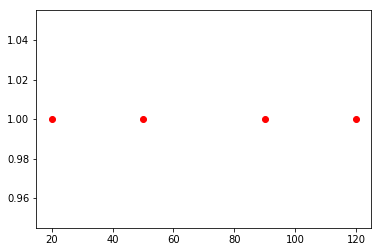

In [37]:
x = cluster_sizes
plt.plot(x,s_max, "ro")

In [ ]:
plt.plot(x, s_mean, "co")
plt.plot(x, s_iqr, "ro")
plt.plot(x, s_var, "bo")
plt.plot(x, s_median, "go")

#### for number of neighbours=10. Only considering the neighbour vectors.


In [ ]:
cluster_labels=[]
cluster_sizes = [20, 50, 90, 120]
for n in cluster_sizes:
    km = KMeans(n_clusters= n, n_jobs=3)
    clusters = km.fit(neighbour_10_matrix)
    cluster_labels.append( clusters.labels_)

In [ ]:
silhoutee_s = [silhouette_samples(neighbour_10_matrix, labels) for labels in cluster_labels]

In [ ]:
s_var = [ np.var(s) for s in silhoutee_s]
s_max = [ np.max(s) for s in silhoutee_s]
s_median = [ np.median(s) for s in silhoutee_s]
s_mean = [np.mean(s) for s in silhoutee_s]
s_iqr = [stats.iqr(s) for s in silhoutee_s]

In [ ]:
x = cluster_sizes
plt.plot(x,s_max, "ro")

In [ ]:
plt.plot(x, s_mean, "co")
plt.plot(x, s_iqr, "ro")
plt.plot(x, s_var, "bo")
plt.plot(x, s_median, "go")

In [ ]:
x[np.argsort(silhoutee_s)[-8:]]

In [ ]:
np.array(silhoutee_s)[np.argsort(silhoutee_s)[-8:]]

### Clustering

In [13]:
style_dict = {'border': "2px solid #000",
              "text-align": "justify"
    
}

In [15]:
%%time
NO_OF_CLUSTERS = 70
km = KMeans(n_clusters= NO_OF_CLUSTERS, n_jobs=3)
clusters = km.fit(neighbour_4_matrix)

CPU times: user 5.64 s, sys: 1.35 s, total: 6.99 s
Wall time: 2min 11s


In [16]:
change_df["cluster_4"] = pd.Series(clusters.labels_, index= change_df.index)
change_grouped_by_tokens_4_neigh = change_df.groupby("cluster_4")

In [17]:
repers_4_neigh = [ change_grouped_by_tokens_4_neigh[["left_string","del_string", "ins_string", "right_string"]].get_group(i).style.set_properties(**style_dict, axis=None).set_caption("group "+ str(i) ).render() for i in range(NO_OF_CLUSTERS)]

In [25]:
all_html = " ".join(repers_4_neigh)
file_name = article_name + "_4_neigh_"+str(NO_OF_CLUSTERS) + "_clusters.html"
file_path = os.path.join("./visualisation", file_name)
with open(file_path, 'wb') as f:
    f.write(all_html.encode())

In [26]:
@interact( clusters_html=fixed(repers_4_neigh), group=range(70))
def display_clusters(clusters_html, group):
     return display(HTML(clusters_html[group]))


interactive(children=(Dropdown(description='group', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

##### Cluster number of neighbour tokens=10, number of clusters =100 

In [253]:
%%time
NO_OF_CLUSTERS = 100
km = KMeans(n_clusters= NO_OF_CLUSTERS, n_jobs=3)
clusters = km.fit(neighbour_10_matrix)

CPU times: user 3.86 s, sys: 1.12 s, total: 4.98 s
Wall time: 1min 25s


In [297]:
change_df["cluster_10"] = pd.Series(clusters.labels_, index= change_df.index)
change_grouped_by_tokens_10_neigh = change_df.groupby("cluster_10")

In [298]:
repers_10_neigh = [ change_grouped_by_tokens_10_neigh[["left_string","del_string", "ins_string", "right_string"]].get_group(i).style.set_properties(**style_dict, axis=None).set_caption("group "+ str(i) ).render() for i in range(NO_OF_CLUSTERS)]

In [299]:
all_html = " ".join(repers_10_neigh)
file_name = article_name + "_10_neigh_"+str(NO_OF_CLUSTERS) +"_clusters.html"
file_path = os.path.join("./visualisation", file_name)
with open(file_path, 'wb') as f:
    f.write(all_html.encode())

In [ ]:
a= HTML(repers[0])
for repr in repers:
    display(HTML( "<br/><br/><br/>"+repr ))

In [300]:
@interact( clusters_html=fixed(repers_10_neigh), group=range(100))
def display_clusters(clusters_html, group):
     return display(HTML(clusters_html[group]))


interactive(children=(Dropdown(description='group', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

In [ ]:
id = list(range(20))
id_str = ["group "+str(i) for i in id]
drop_down = list(zip(id_str, id))
# interact(display_clusters, clusters_html=fixed(repers), group= drop_down);
interact(display_clusters, clusters_html=fixed(repers),  group= drop_down)


In [28]:
%%time
NO_OF_CLUSTERS = 100
km = KMeans(n_clusters= NO_OF_CLUSTERS, n_jobs=3)
clusters = km.fit(ins_del_4_sum_neighbour_matrix)
change_df["cluster_4_full"] = pd.Series(clusters.labels_, index= change_df.index)

CPU times: user 12 s, sys: 9.92 s, total: 21.9 s
Wall time: 4min 13s


In [43]:
change_grouped_by_tokens_4_full = change_df.groupby("cluster_4_full")

In [30]:
repers_4_full = [ change_grouped_by_tokens_4_full[["left_string","del_string", "ins_string", "right_string"]].get_group(i).style.set_properties(**style_dict, axis=None).set_caption("group "+ str(i) ).render() for i in range(NO_OF_CLUSTERS)]

In [31]:
all_html = " ".join(repers_4_full)
file_name = article_name + "_4_full_"+str(NO_OF_CLUSTERS) + "_clusters.html"
file_path = os.path.join("./visualisation", file_name)
with open(file_path, 'wb') as f:
    f.write(all_html.encode())

In [32]:
@interact( clusters_html=fixed(repers_4_full), group=range(100))
def display_clusters(clusters_html, group):
     return display(HTML(clusters_html[group]))


interactive(children=(Dropdown(description='group', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

### Saving the cluster with change object
###### TO-DO: save change object and cluster seperately.

In [27]:
cluster_dir = "../data/clusters/"
file_name = article_name + "_cluster.h5"
full_file_path = os.path.join(cluster_dir, file_name)
with pd.HDFStore(full_file_path, 'w') as store:
    store.put("change_object", change_df, table=False)

/home/ubuntu/anaconda3/envs/wrod2vec/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['ins_tokens', 'del_tokens', 'left_neigh', 'right_neigh', 'left_token', 'right_token', 'left_string', 'ins_string', 'del_string', 'right_string']]

  if self.run_code(code, result):


### Ranking
###### Ranking clustered groups on following parameters.
1. Size of clusters
2. No of unique editors is clusters
3. Total period of cluster. i.e difference between start and end date.
4. Median length of edited token in each cluster.

In [ ]:
rank_by_size = change_grouped_by_tokens.size().sort_values()
rank_by_size

In [ ]:
rank_by_uniq_editor = change_grouped_by_tokens["editor_s"].nunique().sort_values()

In [ ]:
rank_by_period = change_grouped_by_tokens["timestamp"].apply(lambda x: x.max() - x.min()).sort_values()

In [ ]:
rank_by_rate = change_grouped_by_tokens["time_gap"].apply(lambda x: x.mean()).sort_values()

In [ ]:
rank_by_token_length = (change_grouped_by_tokens["ins_token_len"].median() + change_grouped_by_tokens["del_token_len"].median()).sort_values()
rank_by_token_length = ranks_by_token_length /2

In [ ]:
plt.scatter(np.log10(cluster_ranks_by_size), rank_by_uniq_editor)
plt.scatter(np.log10(cluster_ranks_by_size), rank_by_token_length)
plt.scatter(np.log10(cluster_ranks_by_size), np.log10(pd.to_numeric(rank_by_period)))
plt.scatter(np.log10(cluster_ranks_by_size), np.log10(pd.to_numeric(rank_by_rate)))

In [ ]:
change_grouped_by_tokens.get_group(cluster_ranks_by_period.index.tolist()[0])

In [ ]:
change_grouped_by_tokens.get_group(cluster_ranks_by_period.index.tolist()[0])["del_string"].str.cat()

In [ ]:
%%time
silhoutee_s = []
for n in range(2,48,2):
    km = KMeans(n_clusters= n, n_jobs=3)
    clusters = km.fit(ins_del_sum_neighbour_matrix)
    cluster_s = pd.Series(clusters.labels_, index= change_df.index)
    silhoutee_s.append(silhouette_score(change_matrix, cluster_s))

In [ ]:
x = np.arange(2,48,2)
plt.plot(x,silhoutee_s)

In [ ]:
x[np.argsort(silhoutee_s)[-8:]]

In [ ]:
np.array(silhoutee_s)[np.argsort(silhoutee_s)[-8:]]

In [ ]:
%%time
km = KMeans(n_clusters= 12, n_jobs=3)
clusters = km.fit(ins_del_sum_neighbour_matrix)
cluster_s = pd.Series(clusters.labels_, index= change_df.index)
change_df["cluster"] = cluster_s
change_grouped_by_sum = change_df.groupby("cluster")
change_grouped_by_sum.size().plot()

In [ ]:
rank_by_size = change_grouped_by_sum.size().sort_values()
rank_by_size

In [ ]:
rank_by_uniq_editor = change_grouped_by_sum["editor_s"].nunique().sort_values()

In [ ]:
rank_by_period = change_grouped_by_sum["timestamp"].apply(lambda x: x.max() - x.min()).sort_values()

In [ ]:
rank_by_rate = change_grouped_by_sum["time_gap"].apply(lambda x: x.mean()).sort_values()

In [ ]:
rank_by_token_length = (change_grouped_by_sum["ins_token_len"].median() + change_grouped_by_sum["del_token_len"].median()).sort_values()
rank_by_token_length = ranks_by_token_length /2

In [ ]:
plt.scatter(np.log10(cluster_ranks_by_size), rank_by_uniq_editor)
plt.scatter(np.log10(cluster_ranks_by_size), rank_by_token_length)
plt.scatter(np.log10(cluster_ranks_by_size), np.log10(pd.to_numeric(rank_by_period)))
plt.scatter(np.log10(cluster_ranks_by_size), np.log10(pd.to_numeric(rank_by_rate)))

In [ ]:
change_grouped_by_sum.get_group(9)[["del_string", "ins_string"]]